In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd

%matplotlib inline

# Hierarchical Clustering

## What is it?

Hierarchical clustering, like k-means clustering, is another common form of clustering analysis. With this type of clustering - we seek to do exactly what the name suggests: build hierarchies of links that ultimately form clusters. Once these links are determined, they are displayed in what is called a dendrogram - a graph that displays all of these links in a hierarchical manner.

![](./images/denex.png)

To find clusters in a dendrogram, we can cut the graph at a cutoff of our choosing and use that as our mechanism identify clusters - we'll go over this later in the lesson.

## How is Hierarchical Clustering Different from K-Means Clustering?

Much like we learned about k-means clustering, hierarchical clustering is another method for classifying our data. If you recall, in k-means clustering, the algorithm groups data into a pre-defined set of clusters based on various attributes. However in the case of hierarchical clustering, the algorithm builds classifications trees of the data that merges groups of similar data points.

With k-means, the boundaries between the various clusters are distinct and independent (see graph), whereas in hierarchical clustering, there are shared similarities between those groups that are represented by the classification tree. Going further - unlike with k-means, hierarchical clustering does not require you to define "k" as an input.

![](./images/kmeans.png)

All of these attributes can lend themselves to certain clustering situations - for instance, hierarchical clustering is more beneficial for smaller datasets - think about the complexity of a dendrogram from a 1000 point dataset! Likewise, this form of clustering works better when we have binary data or dummy variables: as k-means computes means in forming clusters, performing k-means on a dataset with a significant amount of variables would skew the resulting clusters and distributions.

## How Does Hierarchical Clustering Work? - Demo

In hierarchical clustering, instead of clustering in one step, the clusters are determined over a set of steps. At each step, the algorithm makes a choice to pair up two points based on the surrounding datapoints, with the ultimate goal that these best choices will lead to the best choice of clusters overall. Given the algorithm's method of calculating linkages based on immediate datapoints, it's known as a _greedy_ algorithm.

There are two forms of hierarchical clustering: **agglomerative hierarchical clustering** and **divisive hierarchical clustering**, also known as bottom-up and top-down clustering.

![](./images/hier.png)

Today, we're going to look at one of the most fundamental methods for agglomerative hierarchical cluster, known as linkage clustering. Linkage clustering iterates through datapoints and computes the distance between groups by computing the distance between two neighboring datapoints, using the nearest neighbor technique that was also used by KNN.

To think about the difference between agglomerative vs divisive, with the former we start with the leaves of the tree and build the trunk, and with the latter we start with the trunk of the tree and build the leaves. Both methods are applicable when using hierarchical clustering, it's just a matter of computational preference!

### Hierarchical Clustering in Python

Implementing hierarchical clustering in Python involves calling a function from the SciPy library:

```python
from scipy.cluster.hierarchy import linkage
Z = linkage(X, 'ward')
``` 

Here, `X` represents the matrix of data that we are clustering, and `ward` tells our algorithm which method to use to calculate distance between our newly formed clusters - in this case Ward's Method (which seeks to minimize the variance when forming clusters). 

After we cluster, we can calculate the dendrogram using the `dendrogram()` function from SciPy.

To check how well our algorithm has measured distance, we can use a value known as the _cophenetic correlation coefficient_. This metric, which measures the height of the dendrogram at the point where the last two branches merge, can tell us how well the dendrogram has measured the distance between data points in the original dataset (compared to their non-hierarchical distance) and is a helpful measure to see how well our clustering test has run.

> In other words, is our algorithm gluing points that are far apart from each other because it has no choice left at that point or is it doing so because that would be the most appropriate pair to make?

```python
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(X))
```

Here, we call the cophenetic function using `cophenet` from SciPy and apply it to our clustered set, `Z`, and the distance of our original set, `X`.

> For interpretation, higher values of the _cophenetic correlation coefficient_ are better -- it means that our algorithm has correctly put together clusters that are cohesive.

## Preparing Your Analysis & Handling Data in SciPy

First, let's import the `iris` dataset, loading it in from the `sklearn.datasets` module:

In [2]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Let's do a couple of plots using Seaborn to give us a sense of how the clusters might naturally fall.

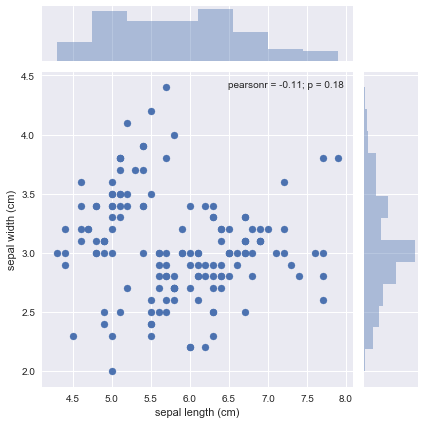

In [3]:
sns.jointplot(x='sepal length (cm)', y='sepal width (cm)', data=df)

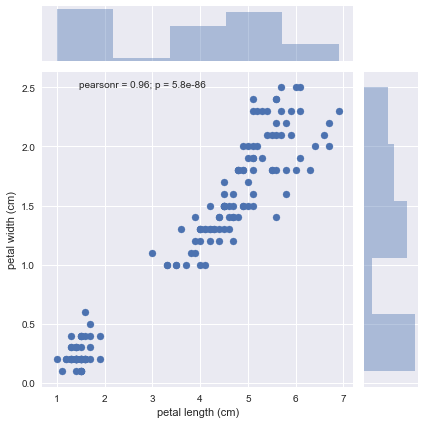

In [4]:
sns.jointplot(x='petal length (cm)', y='petal width (cm)', data=df)

Now, let's convert our data to a matrix to pass to the clustering algorithm - the matrix makes it easier for our algorithm to compute distance. Additionally, we'll standardize our inputs (because we're looking at distance).

In [5]:
ss = StandardScaler()
ss.fit(df)
X = ss.transform(df)

Next, we'll implement the actual clustering algorithm using the ward method:

In [6]:
Z = linkage(X, 'ward')

Now, we can calculate the cophenetic correlation coefficient to see how well our algorithm has measured the distances between the points:

In [7]:
c, coph_dists = cophenet(Z, pdist(X))
print(c)

0.822575433145


This correlation is near 1.0, which suggests that our clustering is fairly cohesive (i.e., our clusters are coherent and well-formed).

Now, let's plot the dendrogram. To do this, we call dendrogram from scipy.cluster.hierarchy and input our links, and rotate the labels so we can view the graph in a more organized matter. We can then plot the denrogram with pyplot from matplotlib.

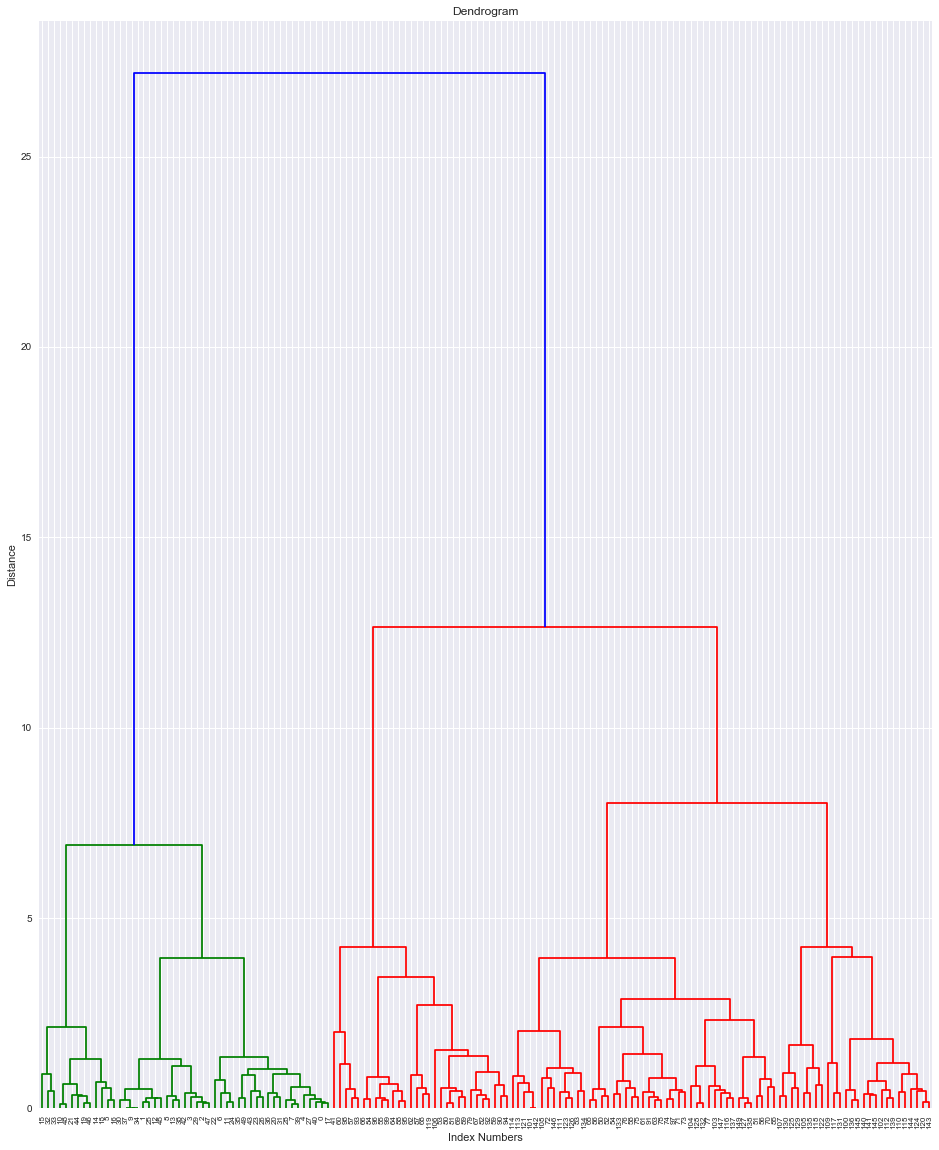

In [8]:
plt.figure(figsize=(16,20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

How to interpret this graph:

1. The values on the x-axis are the **index number** of each point.
2. During each fitting step, the _two closest points_ are paired together.
3. The height of the horizontal line joining two points together is the **ward** distance between those two points.
4. Each successive step of the algorithm pairs together either:
  - the next closest pair of points
  - the next closest pair of clusters
  - the next closest cluster and a point 
5. As the clusters in a given point are farther and farther from each other, the distance between them has to be bigger.
6. If we draw a horizontal line at a given distance, we can see all the clusters that have been made below that distance. Our job as modelers is to pick an appropriate distance.

For our purposes, a distance of 10 looks to be a place where we can make a good set of clusters, so we'll set it there and have the algorithm tell us which points fall into which clusters at that point.

> We may choose where to put that split at one of two ways:
>  - How many clusters do we need for a given purpose?
>  - What separating boundary looks the best?

`clusters` will give us, in order of data points, what cluster they have been assigned to.

In [9]:
max_dist = 10
clusters = fcluster(Z, max_dist, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

Lastly, let's plot our data and assign the class labels as the color:

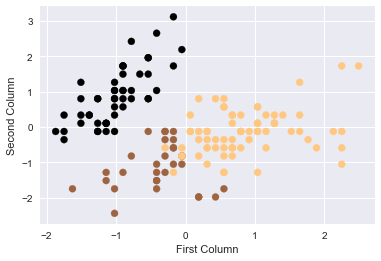

In [10]:
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='copper')
plt.xlabel('First Column')
plt.ylabel('Second Column')
plt.show()

## Check for Understanding 1 (20 Minutes)

For this Check for Understanding, we will be using a (very small) dataset on countries and the languages that their citizens speak. Each row in this dataset is a country and the values in each column are the percent of speakers for that language in the country.

In [11]:
languages = pd.read_csv('datasets/languages.csv')
languages

,country,finnish,swedish,danish,norwegian,english,german,dutch,flemish,french,italian,spanish,portuguese
0,1,0,0,0,0,21,100,2,1,10,2,1,0
1,2,0,0,0,0,5,3,0,0,11,100,1,0
2,3,0,2,3,0,10,7,1,1,100,12,7,1
3,4,0,0,0,0,41,47,100,100,16,2,2,0
4,5,0,0,0,0,14,15,0,59,44,2,1,0
5,6,0,0,0,0,31,100,4,1,92,10,0,0
6,7,0,0,0,0,100,7,0,0,15,3,2,0
7,8,0,0,0,0,9,0,0,0,10,1,2,100
8,9,0,0,0,0,18,100,1,1,4,2,1,0
9,10,0,0,0,0,21,83,1,2,64,23,3,1


Your task for this Check for Understanding is to do the following:

1. Drop `country` from this dataset as it is not informative. Standardize the remaining data.
2. Create a correlation table and heatmap. Are there any languages that appear particularly related? 
3. Use scipy to hierarchically cluster countries together.
4. What is the cophenetic correlation coefficient of your clusters? Does this value suggest that good clusters or bad clusters were made?
4. Display a dendrogram of the results -- in your estimation, where is a good distance to draw the clusters at?
5. **Bonus**: Using the clusters that you have made, use Pandas and plotting to investigate your clusters. What types of countries have been grouped together?

In [12]:
# CfU 1

languages = languages[[col for col in languages.columns if col != 'country']].copy()

ss = StandardScaler()
ss.fit(languages)
X = ss.transform(languages)

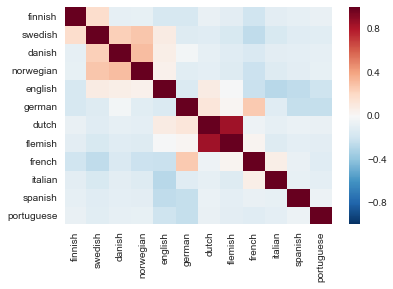

In [13]:
# CfU 2

# Here I'm going to use the original data frame so that I can have access to the column names

sns.heatmap(languages.corr())

```
Instructor answer:

- Dutch and Flemish are highly positively correlated (which is not at all surprising!)
- Nordic languages and Germanic languages tend to weakly positively correlated
- Romance languages (French, Spanish, and Italian) and English and German appear slightly negatively correlated. 
```

In [14]:
# CfU 3

Z = linkage(X, 'ward')

In [15]:
# CfU 4

c, coph_dists = cophenet(Z, pdist(X))
print(c)

0.768042393156


```
Instructor answer:

0.76 is a fairly high cophenetic correlation distance, suggesting that the clusters we have made are fairly cohesive
```

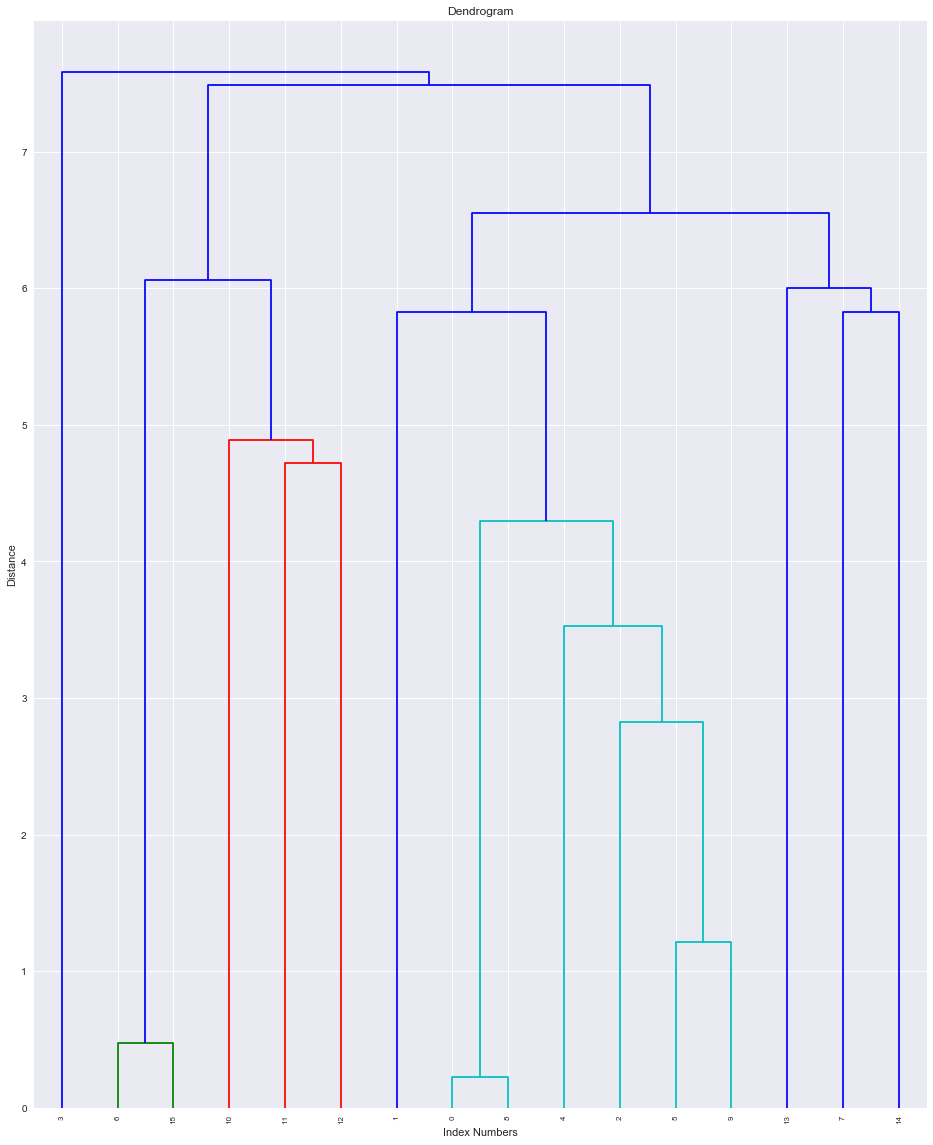

In [16]:
# CfU 5

plt.figure(figsize=(16,20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

```
Instructor answer:

Depending on the need, I would draw my cut off somewhere just above or just below 6. 
I'm going to try my clusters at 5.75, in order to have some interesting patterns to discuss
```

In [17]:
# CfU 6

# Add the clusters back to the original dataframe

languages['clusters'] = fcluster(Z, 5.75, criterion='distance')
print(languages.sort_values('clusters'))
print(languages['clusters'].value_counts())

    finnish  swedish  danish  norwegian  english  german  dutch  flemish  \
6         0        0       0          0      100       7      0        0   
15        0        0       0          0      100       1      0        0   
10        5      100      10         11       43      25      0        0   
11        0       22     100         20       38      36      1        1   
12        0       25      19        100       34      19      0        0   
0         0        0       0          0       21     100      2        1   
2         0        2       3          0       10       7      1        1   
4         0        0       0          0       14      15      0       59   
5         0        0       0          0       31     100      4        1   
8         0        0       0          0       18     100      1        1   
9         0        0       0          0       21      83      1        2   
1         0        0       0          0        5       3      0        0   
7         0 

```
Instructor answer:

Outside of clusters 1, 2, and 3, the rest of our clusters only have one entry. I'll look at the summary stats for each of those three groups, and then will plot a couple of languages as a scatter plot, using the cluster labels as colors
```

In [18]:
languages.loc[(languages['clusters'] == 1)].describe()

,finnish,swedish,danish,norwegian,english,german,dutch,flemish,french,italian,spanish,portuguese,clusters
count,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.000000,2.00000,2.000000,2.0,2.0
mean,0.0,0.0,0.0,0.0,100.0,4.000000,0.0,0.0,8.500000,1.50000,1.000000,0.0,1.0
std,0.0,0.0,0.0,0.0,0.0,4.242641,0.0,0.0,9.192388,2.12132,1.414214,0.0,0.0
min,0.0,0.0,0.0,0.0,100.0,1.000000,0.0,0.0,2.000000,0.00000,0.000000,0.0,1.0
25%,0.0,0.0,0.0,0.0,100.0,2.500000,0.0,0.0,5.250000,0.75000,0.500000,0.0,1.0
50%,0.0,0.0,0.0,0.0,100.0,4.000000,0.0,0.0,8.500000,1.50000,1.000000,0.0,1.0
75%,0.0,0.0,0.0,0.0,100.0,5.500000,0.0,0.0,11.750000,2.25000,1.500000,0.0,1.0
max,0.0,0.0,0.0,0.0,100.0,7.000000,0.0,0.0,15.000000,3.00000,2.000000,0.0,1.0


```
Instructor answer:

This seems completely driven by the high levels of English proficiency
```

In [19]:
languages.loc[(languages['clusters'] == 2)].describe()

,finnish,swedish,danish,norwegian,english,german,dutch,flemish,french,italian,spanish,portuguese,clusters
count,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,1.666667,49.00000,43.000000,43.666667,38.333333,26.666667,0.333333,0.333333,6.666667,1.666667,0.666667,0.333333,2.0
std,2.886751,44.19276,49.568135,48.993197,4.509250,8.621678,0.577350,0.577350,3.055050,1.154701,0.577350,0.577350,0.0
min,0.000000,22.00000,10.000000,11.000000,34.000000,19.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.0
25%,0.000000,23.50000,14.500000,15.500000,36.000000,22.000000,0.000000,0.000000,5.000000,1.000000,0.500000,0.000000,2.0
50%,0.000000,25.00000,19.000000,20.000000,38.000000,25.000000,0.000000,0.000000,6.000000,1.000000,1.000000,0.000000,2.0
75%,2.500000,62.50000,59.500000,60.000000,40.500000,30.500000,0.500000,0.500000,8.000000,2.000000,1.000000,0.500000,2.0
max,5.000000,100.00000,100.000000,100.000000,43.000000,36.000000,1.000000,1.000000,10.000000,3.000000,1.000000,1.000000,2.0


```
instructor answer:

This seems like it must be the Nordic countries -- very high averages and max for Swedish, Danish, and Norweigin, and relatively low levels of other languages
```

In [20]:
languages.loc[(languages['clusters'] == 3)].describe()

,finnish,swedish,danish,norwegian,english,german,dutch,flemish,french,italian,spanish,portuguese,clusters
count,6.0,6.000000,6.000000,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.0
mean,0.0,0.333333,0.500000,0.0,19.166667,67.500000,1.500000,10.833333,52.333333,8.50000,2.166667,0.333333,3.0
std,0.0,0.816497,1.224745,0.0,7.194906,44.329448,1.378405,23.600141,40.445849,8.38451,2.562551,0.516398,0.0
min,0.0,0.000000,0.000000,0.0,10.000000,7.000000,0.000000,1.000000,4.000000,2.00000,0.000000,0.000000,3.0
25%,0.0,0.000000,0.000000,0.0,15.000000,32.000000,1.000000,1.000000,18.500000,2.00000,1.000000,0.000000,3.0
50%,0.0,0.000000,0.000000,0.0,19.500000,91.500000,1.000000,1.000000,54.000000,6.00000,1.000000,0.000000,3.0
75%,0.0,0.000000,0.000000,0.0,21.000000,100.000000,1.750000,1.750000,85.000000,11.50000,2.500000,0.750000,3.0
max,0.0,2.000000,3.000000,0.0,31.000000,100.000000,4.000000,59.000000,100.000000,23.00000,7.000000,1.000000,3.0


```
Instructor answer:

This looks like it must be the French and German speaking countries -- 67.5% German Speaking and 52.33% French speaking.

For scatter plots, let's do English versus German -- we should see something interesting!
```

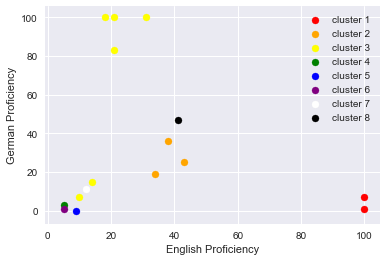

In [21]:
# Matplotlib isn't great at creating scatter plots with labeled groups -- this is an ok workaround

for i, col in enumerate(['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'white', 'black']):
    df = languages.loc[(languages['clusters'] == i+1)]
    plt.scatter(df['english'], df['german'], c=col, label='cluster {}'.format(i+1))
plt.xlabel('English Proficiency')
plt.ylabel('German Proficiency')
plt.legend()

```
Instructor Answer:

We do see four distinct clumps of English v German proficiency: 

1. High English and low German proficiency (all cluster 1)
2. Roughly medium English and German proficiency (all cluster 2 and cluster 8)
3. Low English but high German proficiency (the majority of cluster 3)
4. Low English and low German proficiency (all other observations)

That our clusters fall generally in line with these four (Cluster 1 is great at English, Cluster 2 is generally ok at both languages, and most of Cluster 3 is great at German) suggests that while we may want to tweak our cutoff somewhat, hierarchical clustering is letting us identify trends that exist within the data.
```

### Hierarchical Clustering in sklearn

Scikit-learn also offers a hierarchical clustering algorithm known as [`AgglomerativeClustering`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html):

`AgglomerativeClustering` optionally takes a few different parameters, but most important is the `n_clusters` parameter -- once the algorithm has fit the clusters (such as with the dendrogram), it prunes back those clusters until it hits the number of clusters specified by that parameter. It defaults to using Ward linkage, but this can be changed if required.

There's a little more control (but less deployability) in the scipy version (as well as the very useful dendrogram) but ultimately, the scikit-learn version may be easier to use, given how similar it is to other sklearn techniques we've covered in the past.

We'll show a brief example using the Iris dataset:

In [22]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


We'll begin by standardizing the data:

In [23]:
ss = StandardScaler()
ss.fit(df)
X = ss.transform(df)

Next we'll ask `AgglomerativeClustering` to return back two clusters for Iris:

In [24]:
ag = AgglomerativeClustering(n_clusters=2)
ag.fit(X)
predicted_labels = ag.labels_

We could plot these labels as before:

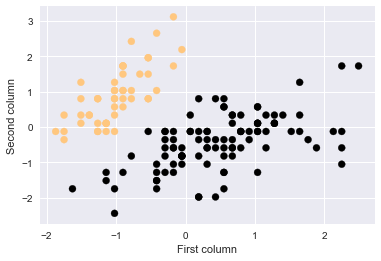

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='copper')
plt.xlabel('First column')
plt.ylabel('Second column')

Unfortunately, sklearn's form of agglomerative clustering doesn't really give us much of an opportuntity to consider how good (or poorly) 2 clusters fits (versus some other number of clusters). Scipy's `dendrogram` gives us a much better visual display and cna help us make decisions that way. 

I'll typically use both -- scipy to help me figure out what a good amount of clusters might be (for example, if there is a very large distance separating the next set of clusters from being joined, that might be a good cutoff). I'll do the actual fitting in sklearn to take advantage of things like a standard API, `Pipeline` objects, etc. afterwards.

## Check for Understanding 2 (20 Minutes)

In this Check for Understanding, we will be using a dataset from the UCI MLR on weekly prices on the [Dow Jones](https://archive.ics.uci.edu/ml/datasets/Dow+Jones+Index) -- it contains 750 weekly observations of stocks on the Dow Jones stock index. Those stocks available during the data were collected are:

		3M		 	MMM
		American Express 	AXP
		Alcoa			AA
		AT&T 			T
		Bank of America		BAC
		Boeing 		 	BA
		Caterpillar 	 	CAT
		Chevron 	 	CVX
		Cisco Systems 		CSCO
		Coca-Cola 	 	KO
		DuPont 		 	DD
		ExxonMobil 	 	XOM
		General Electric 	GE
		Hewlett-Packard		HPQ
		The Home Depot 	 	HD
		Intel 		 	INTC
		IBM 		 	IBM
		Johnson & Johnson 	JNJ	
		JPMorgan Chase 	 	JPM
		Kraft			KRFT
		McDonald's 		MCD
		Merck 		 	MRK
		Microsoft 	 	MSFT
		Pfizer 		 	PFE
		Procter & Gamble 	PG
		Travelers 	 	TRV
		United Technologies 	UTX
		Verizon 	 	VZ
		Wal-Mart 	 	WMT
		Walt Disney 	 	DIS
        
And the features in the dataset are:

 - `quarter`:  the yearly quarter (1 = Jan-Mar; 2 = Apr=Jun).
 - `stock`: the stock symbol (see above)
 - `date`: the last business day of the work (this is typically a Friday)
 - `open`: the price of the stock at the beginning of the week
 - `high`: the highest price of the stock during the week
 - `low`: the lowest price of the stock during the week
 - `close`: the price of the stock at the end of the week
 - `volume`: the number of shares of stock that traded hands in the week
 - `percent_change_price`: the percentage change in price throughout the week
percent_chagne_volume_over_last_wek: the percentage change in the number of shares of stock that traded  - `hands` for this week compared to the previous week
 - `previous_weeks_volume`: the number of shares of stock that traded hands in the previous week
 - `next_weeks_open`: the opening price of the stock in the following week
 - `next_weeks_close`: the closing price of the stock in the following week
percent_change_next_weeks_price: the percentage change in price of the stock in the following week  - `days_to_next_dividend`: the number of days until the next dividend
 - `percent_return_next_dividend`: the percentage of return on the next dividend

In [26]:
stocks = pd.read_csv('datasets/dow_jones_index.csv')
stocks.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


Please attempt the following questions on your own:

1. What data cleaning (missing data, identifiers, data encoded as strings, etc.) do you need to do to prepare this for clustering? Make those changes. Standardize your remaining features.
2. Use scipy to cluster and answer the following questions:
    1. What is the cophenetic correlation coefficient? What does it tell you about the clusters you've made?
    2. Plot a dendrogram. What appears to be a good number of clusters? 
3. Use sklearn to fit a model with your chosen number of clusters (number of stocks in the dataset). Use Pandas and / or plotting to investigate the clusters you have made. What, if any, trends do you find?

In [27]:
# CfU 1

# We need to change the open, high, low, next_weeks_open, next_weeks_close, and close features into floats (versus strings)
# Drop quarter, stock, and date from our new dataset
# fill in nulls with 0 (they are the first week and have no previous changes to look back at)

stocks_mod = stocks.copy()
for col in ['open', 'high', 'low', 'next_weeks_open', 'next_weeks_close', 'close']:
    stocks_mod[col] = stocks_mod[col].apply(lambda x: float(x.replace('$', '')))
stocks_mod.fillna(0, inplace=True)
stocks_mod = stocks_mod[[col for col in stocks_mod.columns if col not in ['quarter', 'stock', 'date']]].copy()

ss = StandardScaler()
ss.fit(stocks_mod)
X = ss.transform(stocks_mod)

0.442062419385


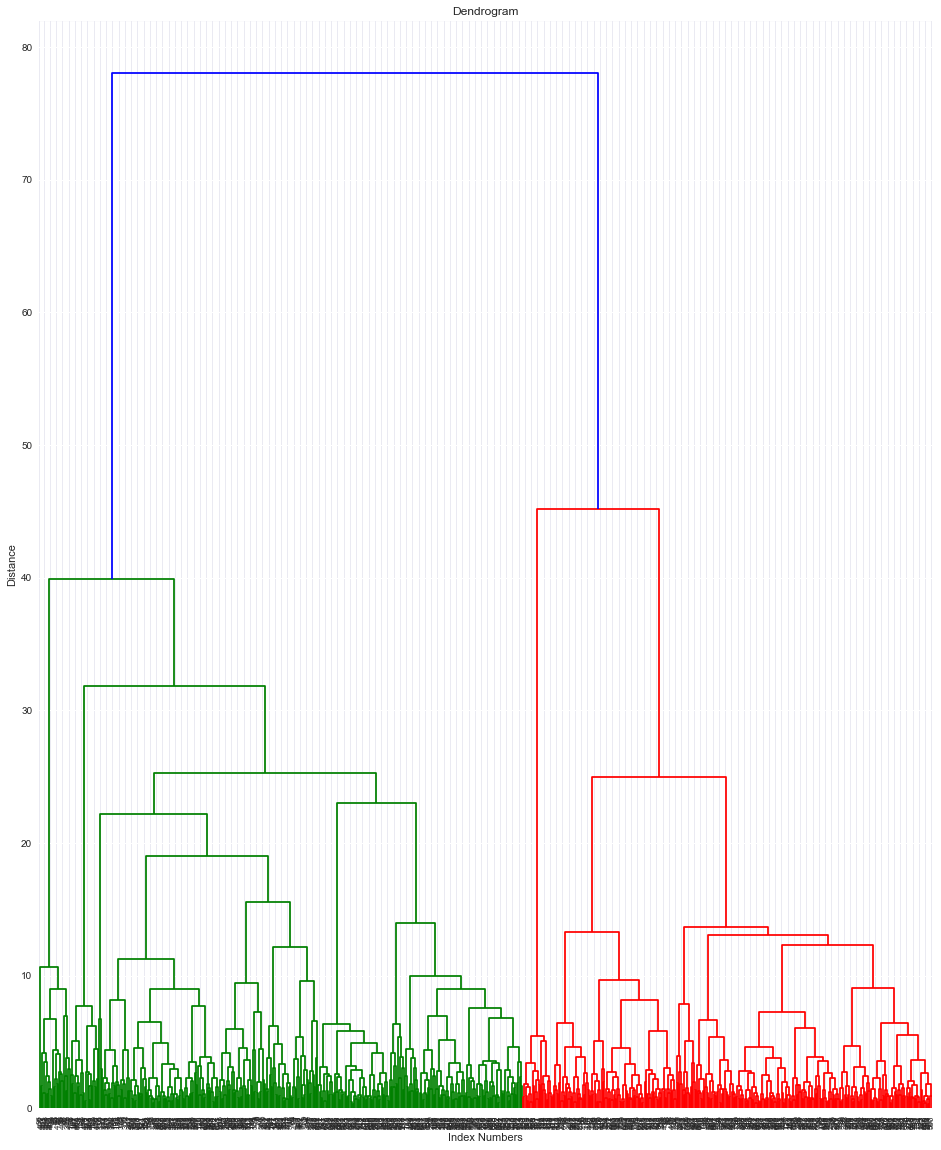

In [28]:
# CfU 2

Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
print(c)

plt.figure(figsize=(16,20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

```
Instructor answer:

If I did not know this dataset, I would likely pick a distance somewhere between 20 and 40 -- 20 clusters would give me 9 clusters while 40 would give me 3-5. Your choice of clusters should be influenced partially by your business need and partially by tools like the dendrogram to give you a better estimate. In this case, a distance of 20 is where there's a large distance between forming one cluster and the next cluster forming. This suggests that those clusters are already fairly far apart. 
```

In [29]:
# CfU 3 

# There are a lot of ways to address what each cluster is trying to do. Here, I'm going to do two things:
# 1) What is the low versus high price for each cluster (via a scatter plot)
# 2) Looking at a boxplot of volume by cluster

ag = AgglomerativeClustering(n_clusters=5)
ag.fit(X)

stocks_mod['clusters'] = ag.labels_

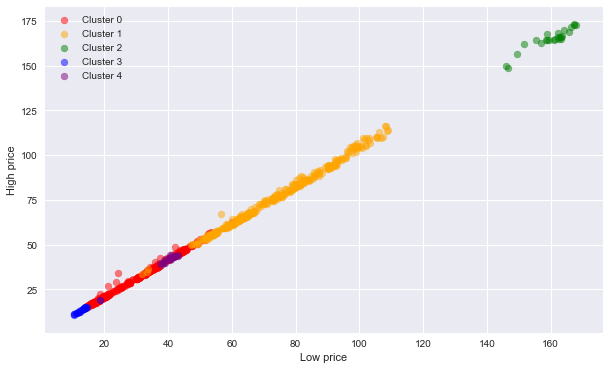

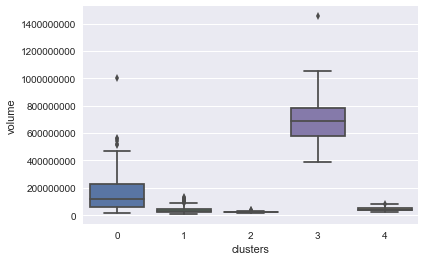

In [30]:
plt.figure(figsize=(10, 6))
for color, cluster in zip(['red', 'orange', 'green', 'blue', 'purple'], [0, 1, 2, 3, 4]):
    clustered_df = stocks_mod.loc[(stocks_mod['clusters'] == cluster)]
    plt.scatter(clustered_df['low'], clustered_df['high'], c=color, alpha=0.5, label='Cluster {}'.format(cluster))
plt.ylabel('High price')
plt.xlabel('Low price')
plt.legend()
plt.show()
sns.boxplot(x='clusters', y='volume', data=stocks_mod)
plt.ticklabel_format(style='plain', axis='y')

```
Instructor answers

Cluster 0: High / Low prices between $20-$40, but higher volume than most clusters
Cluster 1: Widest range of prices ($50-$125), but fairly low volume
Cluster 2: Highest prices (over $140 each), but smallest volue
Cluster 3: Essentially penny stocks -- lowest prices but highest volume of trade
Cluster 4: Midrange for both price and volume of trades
```

# Cluster Evaluations

As we don't have a real version of "the truth" (like we do in a structured machine learning world), it's important to really dive into how we assess and discuss clusters that we have created.

In this section, we're going to identify a few techniques that you can do to evaluate how well (or poorly) your clusters fit. However, because we don't know the "true" values for our clusters, ultimately **we** will be the ones making the determination of whether or not to keep fitting a clustering algorithm. There is no objective truth that we'll be able to use to judge our goodness of fit. 

### Visually Evaluating Clusters

When evaluating clusters, the best and easiest method when the data allows is to visually examine the output of the clustering algorithm. After we run the algorithm, we can plot the clusters to see where the clusters are and if they make sense. 

It can be tricky to plot out data that has >2 dimensions (as sadly, we're limited to 3 dimensions for sight) -- there are some options around that (in practice, dimensionality reduction techniques such as t-SNE or PCA, or plotting various dimensions against each other) but those techniques can also be sensitive to hyperparameters or feature selection.

Scatterplots and boxplots (in particular) can be very useful in these cases.

### Evaluating Clusters without a ground truth -- Silhouette Score

The silhouette evaluates the validity of your model's clusters based on the ideas of cohesion and separation.

#### Cohesion

Cohesion measures clustering effectiveness within a cluster. It is calculated:

- C: a given cluster
- c: the centroid of that cluster
- d: distance metric (such as euclidian)
- x: observation
- $\in$: a set of / containing

$$ \hat{C}(C_i) = \sum_{x \in C_i} d(x, c_i)$$

#### Separation

Separation measures clustering effectiveness between clusters. It is calculated (using the same notation as above):

$$ \hat{S}(C_i, C_j) = d(c_i, c_j) $$

($i$ and $j$ denote two different clusters)

![](images/cohesion.jpg)

#### Silhouette coefficient

The silhouette coefficient combines the cohesion and the separation into a single metric:

$$ SC_i = \frac{b_i - a_i}{\max({a_i, b_i})}$$

- $a_i$ = mean intra-cluster distance of the sample to others within the cluster (cohesion)
- $b_i$= the mean nearest-cluster distance from the sample to those within the nearest non-assigned cluster (separation)

The coefficient ranges from -1 to 1:

- A score of 1 indicates the maximum cohesion and separation of clusters.
- A score of -1 indicates the minimum cohesion and separation of clusters.

![](./images/sil_coef_visual.jpg)

When you calculate the silhouette score using sklearn you get out a single number. This is the average silhouette score for all of the individual observations.

In general, we want separation to be high and cohesion to be low. This corresponds to a value of SC close to +1.

A negative silhouette coefficient means the cluster radius is larger than the space between clusters, and thus clusters overlap. Another way to think about this is that negative values indicate that non-assigned clusters are more similar than the assigned cluster.

We can use the silhouette coefficient to determine an number of clusters. **It is important to keep in mind that this is still a subjective measure and not an official measure of quality. It can help you but it's no substitute for knowing your data.**

Visually inspecting your data and evaluating how the silhouette changes across numbers of clusters can give you a rough sense of the quality for K clusters in terms in cohesion and seperation.

### The Elbow Method

If we are using `KMeans`, we can also make use of the Elbow method. In essence, we will plot the average distance of all points from their closest centroid for a number of candidate clusters. When doing this, we should see an elbow or kink point where the rate of change of the average distance slopes off.

Let's do a quick example with the Iris prices dataset that we worked with earlier:

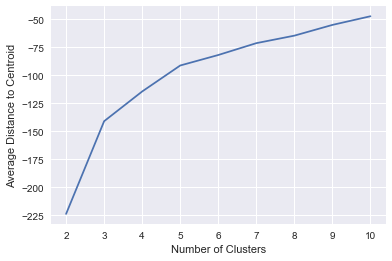

In [31]:
ss = StandardScaler()
ss.fit(df)
X = ss.transform(df)

distances = []
for clusters in range(2, 11):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(X)
    distances.append(kmeans.score(X))
    
plt.plot(list(range(2, 11)), distances)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')

At k=3, we see a stark change in the rate of change (with a more minor one at 5) -- these might be good values to investigate. 

One major challenge with this approach is that there is no ambiguous location to choose. In most cases, this will be a good place for a hint more than anything else.

## Check for Understanding (15 Minutes)

1. Pick one of the other two datasets we have used in this section (Stocks or Language)
2. Use the elbow method to find a couple of number of potential clusters (using KMeans)
3. Report the average silhouette score for each of those potential number of clusters -- is one better or worse than the other?

In [32]:
stocks_mod = stocks.copy()
for col in ['open', 'high', 'low', 'next_weeks_open', 'next_weeks_close', 'close']:
    stocks_mod[col] = stocks_mod[col].apply(lambda x: float(x.replace('$', '')))
stocks_mod.fillna(0, inplace=True)
stocks_mod = stocks_mod[[col for col in stocks_mod.columns if col not in ['quarter', 'stock', 'date']]].copy()

ss = StandardScaler()
ss.fit(stocks_mod)
X = ss.transform(stocks_mod)

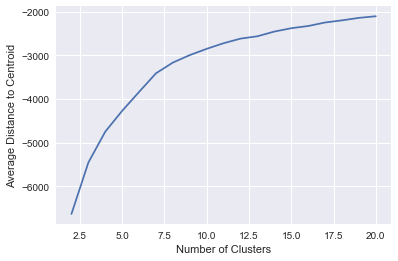

In [33]:
distances = []
for clusters in range(2, 21):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(X)
    distances.append(kmeans.score(X))
    
plt.plot(list(range(2, 21)), distances)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')

```
Instructor answer:

This lacks a clear place for a kink point -- I'm going to try 5, 7, and 10 for my potential clusters though
```

In [34]:
for cluster in [5, 7, 10]:
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    print('{}: {}'.format(cluster, silhouette_score(X, labels)))

5: 0.24708790400522443
7: 0.23450351907818745
10: 0.2182944988127781


```
Instructor answer:

Does not look like there's a big difference between 7 and 10, but 5 clusters seems to be a stronger choice than the other two.
```

## Evaluating clusters when the ground truth is available

The silhouette score is a particularly useful metric in that it does not require us to have the true labels for the clusters (which is most often the case if we need to do clustering to begin with!).

Very, very rarely we have some true labels available (though, that begs the question as to whether or not it makes sense to use an unstructured technique when your data can be modeled with a structured technique). When the true labels are available, there are other methods we can use to evaluate the performance of our clustering algorithm and choice of clusters.

- Completeness Score
- Homogeneity
- V Measure Score
- Mutual Information Score

For each of these techniques, I'll score how well it performs on the Iris dataset:

In [35]:
ss = StandardScaler()
ss.fit(df)
X = ss.transform(df)

targets = iris.target

km = KMeans(n_clusters=3)
km.fit(X)

predicted_labels = km.predict(X)

#### Completeness score

Completeness indicates that all members of a given class are assigned to the same cluster.

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster. (If a cluster contains all of the data points of a single class.)

Score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

In [36]:
from sklearn.metrics import completeness_score
completeness_score(targets, predicted_labels)

0.65984767796277588

This looks like a pretty good set of clusters!

#### Homogeneity

Homogeneity indicates each cluster contains only members of a single class.

A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

Score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling

In [37]:
from sklearn.metrics import homogeneity_score
homogeneity_score(targets, predicted_labels)

0.65912650180490084

Unsurprisingly, this scores fairly well on homogeneity. 

#### V measure score

The V measure score is a combination of the homogeneity and completeness metrics -- it is 2 times the quotient of the completeness and homogeneity scores divided by their sum (in other words, the harmonic mean of those two scores)

In [38]:
from sklearn.metrics import v_measure_score
v_measure_score(targets, predicted_labels)

0.65948689272491801

Because V Measure Score is the harmonic mean of two strongly performing metrics, this is (unsurprisingly) high as well.

### Mutual information score

Mutual information measures the agreement between two assignments (clusters, in this case).

There are various mutual information scores in Sklearn. Be wary of the basic `mutual_info_score` as the output is not normalized, thus making it harder to compare across runs:

$${\displaystyle MI(X;Y)=\sum _{y\in Y}\sum _{x\in X}p(x,y)\log {\left({\frac {p(x,y)}{p(x)\,p(y)}}\right)},}$$

Where:

$MI(X;Y)$ is the mutual information of group $X$ and $Y$ which can be predicted vs. true.

$P(x,y)$ is the probability that observation $x$ in group $X$ is the same as observation $y$ in group $Y$. In other words, the probability that the predicted value (or cluster) and true value are the same.

$P(x)$ is the probability of observation $x$ in group $X$, and $P(y)$ is the probability of observation $y$ in group $Y$.

In [39]:
from sklearn.metrics import mutual_info_score
mutual_info_score(targets, predicted_labels)

0.72412447466968699

Because it is not guaranteed to be between 0 and 1, it's better to use the adjusted mutual information score, which will normalize the result so that it always comes out be between 0 and 1.

In [40]:
from sklearn.metrics import adjusted_mutual_info_score
adjusted_mutual_info_score(targets, predicted_labels)

0.65486030588072708